In [2]:
%load_ext autoreload
%autoreload 2

In [141]:
import abc
import einx
import torch
import torch.nn as nn
import torch.distributions as D
import torchvision
import seaborn as sns

from torch import Tensor
from torch.nn import Module
from einops import rearrange, repeat

In [136]:
import flow

In [137]:
sns.set_theme()

In [ ]:
class Sampleable(abc.ABC):
    @abc.abstractmethod
    def sample(self, samples: torch.Size) -> Tensor:
        raise NotImplementedError()


class CirclesDistrib(Module, Sampleable):
    _dummy: Tensor

    def __init__(self, *args, mean: Tensor, scale: Tensor, n_modes: int, offset_degree: float = 0., radius: float = torch.pi, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        assert  mean.size() == (2,)
        assert scale.size() == (2,)

        theta = 2 * torch.pi * torch.arange(n_modes) / n_modes
        mean_x = radius * torch.cos(theta)
        mean_y = radius * torch.sin(theta)
        means = rearrange([mean_x, mean_y], 'b n -> b n')

        rot_degree= torch.tensor(offset_degree)
        rot = torch.deg2rad(rot_degree)
        rot_mat = torch.tensor([
            [torch.cos(rot), -torch.sin(rot)],
            [torch.sin(rot),  torch.cos(rot)]
        ])

        means = rot_mat @ means
        means = (mean + means.T).T
        scale = repeat(scale, 'd -> d n', n=n_modes)

        self._dist = D.Normal(means, scale)
        self.register_buffer('_dummy', torch.empty((0,)))

    def sample(self, samples: torch.Size) -> Tensor:
        return self._dist.sample(samples).to(self._dummy.device)


class CheckerboardDistrib(Module, Sampleable):
    _dummy: Tensor

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def sample(self, samples: torch.Size) -> Tensor:
        pass

<Axes: xlabel='None', ylabel='None'>

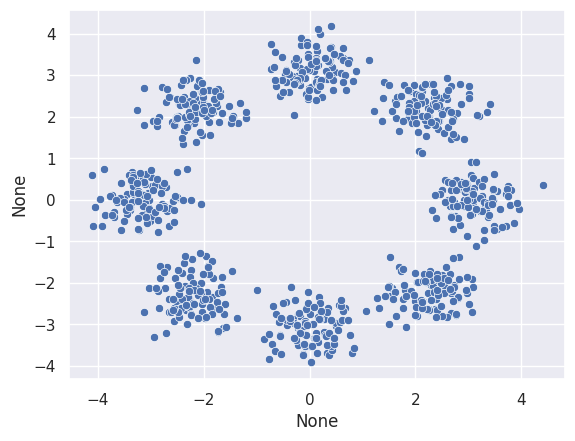

In [ ]:
degrees = 5.0
radius = 1.0
n_modes = 8

circles = CirclesDistrib(
    mean=torch.zeros((2,)),
    scale=.4 * torch.Tensor([1., 1.]),
    offset_degree=90.0,
    radius=1 * torch.pi,
    n_modes=8,
)

samples = circles.sample((100,))
samples = rearrange(samples, 'n d m -> d (n m)')
x = samples[0, :]
y = samples[1, :]
sns.scatterplot(x=x, y=y)